From the dataset we observe a few things:
- This is a multilabel image classification problem
    - one or two possible types per image, so not multiclass
- We could make this multiclass if we consider combination types as their own class
    - not sure tho
- there is a class imbalance, far more normal and water types. And ice types are a fifth the size of the largest class
- This [guide](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/) will help

Notes:
- one model for each type, which will give a probablity score for each class
- the top two classes for each image will be the predicted types
    - the second type will have to be above a certain threshold else one type is predicted
    - Our class probabilities are independent of each other

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train = pd.read_csv('image_tagging/train.csv', nrows=10000) # set limit, delete "nrows" to undo
train.drop(['Name'],axis=1,inplace=True)
train.head()

,Key,Type,normal,fire,water,grass,electric,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,110.95,"poison, ground",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,155.408,"fire, fairy",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,360.381,"grass, psychic",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6.142e,"fire, flying",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,289.175,"bug, fairy",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [4]:
train.columns

Index(['Key', 'Type', 'normal', 'fire', 'water', 'grass', 'electric', 'ice',
       'fighting', 'poison', 'ground', 'flying', 'psychic', 'bug', 'rock',
       'ghost', 'dragon', 'dark', 'steel', 'fairy'],
      dtype='object')

In [5]:
TRAINING_DATASET = "/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input"
IMAGE_SIZE = (256,256,3)

train_image = []
for i in tqdm(range(train.shape[0])):
    # we want them to be 256x256 images 
    img = image.load_img(f"{TRAINING_DATASET}/{train.at[i, 'Key']}.png",target_size=IMAGE_SIZE)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 10000/10000 [00:19<00:00, 506.57it/s]


In [6]:
X.shape

(10000, 256, 256, 3)

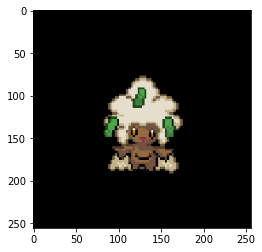

In [7]:
plt.imshow(X[2])

In [8]:
train['Type'][2]

'grass, psychic'

In [9]:
y = np.array(train.drop(['Key', 'Type'],axis=1))
y.shape

(10000, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [11]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=IMAGE_SIZE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='sigmoid')) # make equal to num classes

2024-11-28 23:28:30.106633: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 23:28:31.279020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40973 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 32)        0

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/200


2024-11-28 23:28:37.839080: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-11-28 23:28:38.467188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-28 23:28:38.468105: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-28 23:28:38.468119: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-11-28 23:28:38.468852: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-28 23:28:38.468892: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-11-28 23:28:39.350036: I tensorflow/stream_executor/cuda/c

141/141 [==============================] - 8s 31ms/step - loss: 0.4149 - accuracy: 0.0956 - val_loss: 0.3365 - val_accuracy: 0.2000
Epoch 2/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3600 - accuracy: 0.1310 - val_loss: 0.3362 - val_accuracy: 0.1990
Epoch 3/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3515 - accuracy: 0.1574 - val_loss: 0.3346 - val_accuracy: 0.1990
Epoch 4/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3485 - accuracy: 0.1714 - val_loss: 0.3345 - val_accuracy: 0.1990
Epoch 5/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3456 - accuracy: 0.1822 - val_loss: 0.3361 - val_accuracy: 0.1990
Epoch 6/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3435 - accuracy: 0.1926 - val_loss: 0.3344 - val_accuracy: 0.1990
Epoch 7/200
141/141 [==============================] - 3s 24ms/step - loss: 0.3417 - accuracy: 0.1996 - val_loss: 0.3342 - val_accuracy: 0.1990
Epoc

In [15]:
model.save('200_epoch.keras')

In [24]:
import csv

file_path = "image_tagging/all_pokemon_to_type.csv"
pokedex = {}

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = row['Key']
        value = {col: row[col] for col in row if col != 'Key'}
        pokedex[key] = value

print(pokedex["338.287i"])

{'Type': 'dark, fairy', 'Name': 'Zoroark/Gardevoir', 'Body': '338', 'Head': '287'}


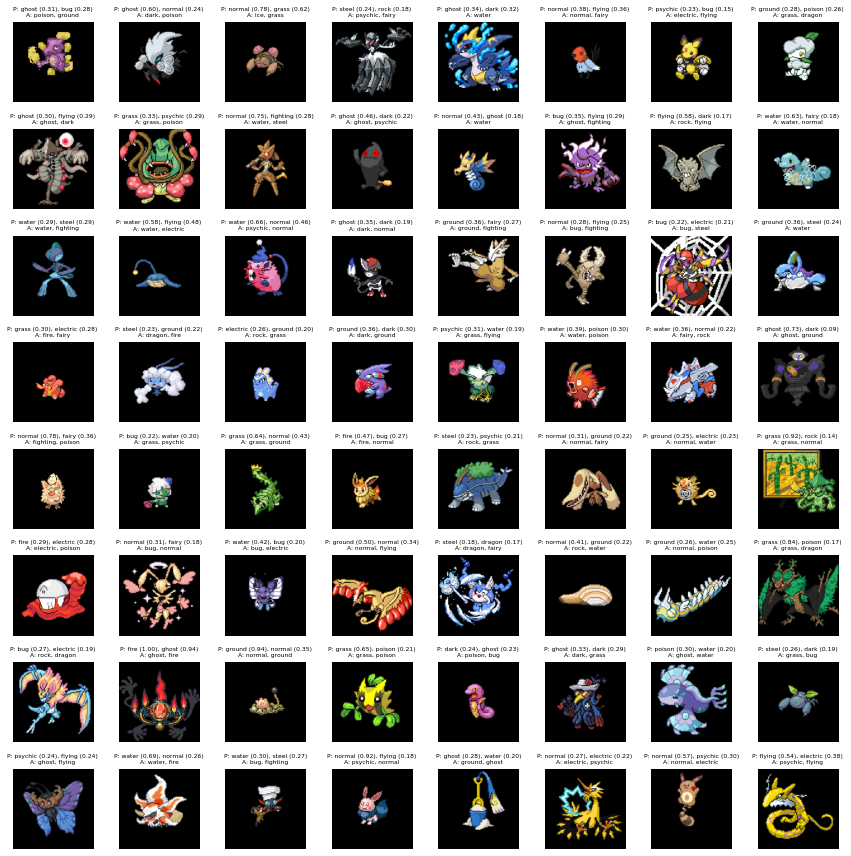

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Constants
GRID_SIZE = 8  # 8x8 grid
OUTPUT_FILE = "predictions_grid.png"  # Output file name

# Variables
count = 0
fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(12, 12))
axes = axes.flatten()

# Iterate through the dataset
for idx, file_name in enumerate(os.listdir(TRAINING_DATASET)):
    if count >= GRID_SIZE * GRID_SIZE:  # Limit to 64 images
        break
    
    # Load and preprocess the image
    img_path = os.path.join(TRAINING_DATASET, file_name)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    classes = np.array(train.columns[2:])
    
    # Make predictions
    proba = model.predict(img_array.reshape(1,256,256,3))
    top_2 = np.argsort(proba[0])[:-3:-1]  # Get top 2 predictions
    top_2_predictions = [f"{classes[i]} ({proba[0][i]:.2f})" for i in top_2]
    
    # Get ground truth
    ground_truth = pokedex[file_name[:-4]]["Type"]
    
    # Plot image in grid
    axes[idx].imshow(img)
    axes[idx].axis('off')  # Turn off axis
    axes[idx].set_title(f"P: {', '.join(top_2_predictions)}\nA: {ground_truth}", fontsize=6)
    
    count += 1

# Adjust layout and save the grid
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()